# CNTK 103: Part A - MNIST Data Loader

Это пособие направлено на новичков в машинном обучении, решивших начать свой путь с CNTK. Мы предполагаем, что вы завершили или знакомы с CNTK 101 и 102. В этом уроке мы загрузим и предварительно обработаем изображения цифр MNIST, которые будут использоваться для создания разных моделей для распознавания рукописных цифр. Мы будем распространять CNTK 101 и 102 для применения к этому набору данных. Кроме того, мы представим сверточную сеть для достижения превосходной производительности. Это первый пример, где мы будем обучать и оценивать модель на основе нейронной сети по данным реального мира.  

CNTK 103 учебник разделен на несколько частей:
- Часть A: Ознакомьтесь с базой данных [MNIST](http://yann.lecun.com/exdb/mnist/) которая будет использоваться позже в учебнике
- Последующие части этой серии 103 будут использовать данные MNIST с различными типами сетей.

In [1]:
# Загрузка необходимых компонентов
from __future__ import print_function
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import struct
import sys

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Config matplotlib для встроенного построения
%matplotlib inline

## Загрузка данных

Мы загрузим данные на локальный компьютер. База данных MNIST содержит стандартные рукописные цифры, которые широко используются для обучения и тестирования алгоритмов машинного обучения. Он имеет обучающий набор из 60 000 изображений и тестовый набор из 10 000 изображений с каждым изображением 28 х 28 пикселей. Этот набор прост в использовании и визуализируется на любом компьютере.

In [2]:
# Функции для загрузки изображений MNIST и распаковки обучающий и тестовый набор.
# - loadData считывает изображение и форматирует его в массив длиной 28x28
# - loadLabels считывает соответствующие данные метки, по одному для каждого изображения
# - загружает загруженные изображения и данные ярлыков в комбинированный формат, 
#   который будет читаться позже с помощью текстового считывателя CNTK

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))


## Загрузите данные

Данные MNIST предоставляются в качестве набора для обучения и тестирования. Учебный набор имеет 60000 изображений, в то время как тестовый набор содержит 10000 изображений. Загрузим данные.

In [3]:
# URL-адреса для обучающих изображений и данных метки
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)

# URL-адреса тестового изображения и данных метки
url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)

Done.
Done.
Done.
Done.


## Визуализация данных

Image Label:  3


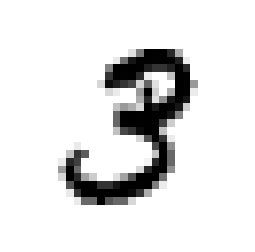

In [4]:
# Построить случайное изображение
sample_number = 5001
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

## Сохранить изображения

Сохраните изображения в локальном каталоге. При сохранении данных мы сглаживаем изображения до вектора (пиксели 28x28 пикселей становятся массивом длиной 784 точек данных).

![](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

Метки кодируются как [1-hot]( https://en.wikipedia.org/wiki/One-hot) кодирование  (метка 3 с 10 цифрами становится `0001000000`, где первый индекс соответствует цифре `0` и последний соответствует цифре to digit `9`.

![](https://www.cntk.ai/jup/cntk103a_onehot.png)

In [6]:
# Сохраняем файлы данных в формате, совместимом с программой чтения CNTK
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)


In [8]:
# Сохраняем обучающие и проверочные файлы (предпочитайте путь по умолчанию для данных - " default")
data_dir = os.path.join("..", "Examples", "Image", "DataSets", "MNIST")
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

print('Done')

Writing train text file...
File already exists data\MNIST\Train-28x28_cntk_text.txt
Writing test text file...
File already exists data\MNIST\Test-28x28_cntk_text.txt
Done


**Рекомендуемые исследования**

Можно манипулировать данными для повышения производительности системы машинного обучения. Мы предлагаем сначала использовать данные, созданные в этом учебнике, и запустить классификатор в последующих частях серии учебников CNTK 103. После того, как у вас есть базовый уровень с классификацией данных в его первоначальной форме, вы можете использовать различные методы манипуляции данными для дальнейшего улучшения модели.

Существует несколько способов изменения (преобразования) данных с помощью считывателей CNTK. Однако, чтобы понять, как эти преобразования могут повлиять на точность обучения и тестирования, мы настоятельно рекомендуем людям попробовать различные варианты трансформации.

- Перемешайте данные обучения (измените порядок строк). Подсказка: используйте `permute_indices = np.random.permutation(train.shape[0])`. Затем запустите часть B учебника с помощью этих вновь переставляемых данных.
- Добавление шума к данным часто может улучшить [generalization error](https://en.wikipedia.org/wiki/Generalization_error). Вы можете увеличить тренеровочный набор, добавив шум (сгенерированный с помощью numpy, hint: use `numpy.random`) к учебным изображениям. 
- Искажение изображений с помощью [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) (переводы или ротации).